In [1]:
using Plots, LinearAlgebra, DifferentialEquations, StatsBase, Distributions, DifferentialEquations.EnsembleAnalysis
using Suppressor, Printf

In [2]:
plotlyjs()

WebIO._IJuliaInit()

Plots.PlotlyJSBackend()

In [3]:
function simGradFlow(f, u0, tspan)
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob)
    return sol
end;

function plotHist(data, d; D::Union{MvNormal, Nothing}=nothing)
    h = fit(Histogram, Tuple(cord for cord in data), nbins=nbins)
    h = normalize(h, mode=:pdf);
    if d==1
        display(plot(h))
#         gui()
    elseif d==2
        x, y = histParams(h)

        x1 = first(x)
        x2 = last(x)
        y1 = first(y)
        y2 = last(y)
        
        lim_min = min(x1, x2, y1, y2)
        lim_max = max(x1, x2, y1, y2)
        
        display(plot(h, xlims=(lim_min, lim_max), ylims=(lim_min, lim_max)))
        x, y = histParams(h)
        p = plot(x, y, h.weights, st=:surface, xlims=(lim_min, lim_max), ylims=(lim_min, lim_max));
        if !isnothing(D)
            Dz = map(z -> pdf(D, collect(z)), Iterators.product(x, y))
            wireframe!(x, y, Dz)
        end
        display(p)
#         gui()
    end;
end;

function simLangevin(f, g, u0, tspan; trajectories=10000, nbinsbins=50, D::Union{MvNormal, Nothing}=nothing)
    d = length(u0)
    t = tspan[2]
    
    prob = SDEProblem(f, g, u0, tspan);
    function prob_func(prob, i, repeat)
        remake(prob, u0 = randn(d) + prob.u0)
    end
    ensembleprob = EnsembleProblem(prob, prob_func=prob_func);
    sol = solve(ensembleprob, SRIW1(), trajectories=trajectories);
    
    data = componentwise_vectors_timepoint(sol, tspan[2]);
    
    plotHist(data, d, D=D)
    
    return sol    
end;

function histParams(h)
    gap1 = (h.edges[1][2] - h.edges[1][1])/2
    gap2 = (h.edges[2][2] - h.edges[2][1])/2

    xlen, ylen = size(h.weights)

    x = LinRange(first(h.edges[1])+gap1, last(h.edges[1])-gap1, xlen)
    y = LinRange(first(h.edges[2])+gap2, last(h.edges[2])-gap2, ylen);
   return x, y 
end;

function plotHistChange(sol, ts)
    hists = []
    lim_min = Inf
    lim_max = -Inf
    for t in ts
        data = componentwise_vectors_timepoint(sol, t)
        h = fit(Histogram, Tuple(cord for cord in data), nbins=nbins)
        h = normalize(h, mode=:pdf);
        x, y = histParams(h);
        
        x1 = first(x)
        x2 = last(x)
        y1 = first(y)
        y2 = last(y)
        c_min = min(x1, x2, y1, y2)
        c_max = max(x1, x2, y1, y2)
        if c_min < lim_min
            lim_min = c_min
        end
        if c_max > lim_max
            lim_max = c_max
        end
        
        push!(hists, (x, y, h.weights))
    end
    t = ts[1]
    p = wireframe(hists[1][1], hists[1][2], hists[1][3], color=1, label="t=$t$(@sprintf("%d", t))", xlims=(lim_min, lim_max), ylims=(lim_min, lim_max))
    c = 2
    for hist in hists[2:end]
        t = ts[c]
        wireframe!(hist[1], hist[2], hist[3], color=c, label="t=$t$(@sprintf("%d", t))", xlims=xlims(p), ylims=ylims(p))
        c += 1
    end
    display(p)
    return
end;

function convertPolar(x)
    r = norm(x)
    if x[2] >= 0
        phi = acos(x[1]/r)
    else
        phi = -acos(x[1]/r)
    end
    return r, phi
end;

unzip(a) = map(x->getfield.(a, x), fieldnames(eltype(a)));

In [26]:
function make_f(Vgrad)    
    function f(u, p, t)
        return -Vgrad(u)
    end;
    return f
end;

function g(u, p, t)
    return sqrt(2)
end;

function g_0(u, p, t)
    return 0
end;

In [5]:
trajectories = 10000
nbins = 50;

In [46]:
T = 1

F_(x) = x[1]^2-x[2]
F(x) = 0.5*F_(x)^2
Fgrad(x) = F_(x) * [2*x[1], -1];




function g1_(du, u, p, t)
    x = u[1]
    y = u[2]
    
    c = 1+4*x^2
    du[1, 1] = sqrt(2)/c
    du[1, 2] = sqrt(2)*2*x/c
    du[2, 1] = sqrt(2)*2*x/c
    du[2, 2] = sqrt(2)*4*x^2/c
    
end

function g2_(du, u, p, t)
    x = u[1]
    y = u[2]
    
    c = 1+4*x^2
    du[1, 1] = sqrt(2)*4*x^2/c
    du[1, 2] = -sqrt(2)*2*x/c
    du[2, 1] = -sqrt(2)*2*x/c
    du[2, 2] = sqrt(2)/c
    
    
end

function g_(du, u, p, t)
    du[1, 1] = sqrt(2)
    du[1, 2] = 0
    du[2, 1] = 0
    du[2, 2] = sqrt(2)
end

# function make_weird_g_(Vgrad)
#     function g_(u)
#         x = u[1]
#         norm_ = sqrt(2/(1+4*x^2))
#         du[1, 1] =norm_ * 4*x^2
#         du[1, 2] = -norm_* 2 * x
#         du[2, 1] = -norm_* 2 * x
#         du[2, 2] = norm_
#     end
# return g_
# end;

function make_f2_(Vgrad)    
    function f2_(du, u, p, t)
        du = -Vgrad(u)
    end;
    return f2_
end;

function f_(du, u, p, t)
   du = 0; 
end;

In [97]:
c = -0.5
u0 = [c, c^2];

tmax = 5
d = 2

f2_ = make_f2_(Fgrad)
f = make_f(Fgrad);

prob = SDEProblem(f2_, g2_, u0, (0, tmax), noise_rate_prototype = zeros(d, d));
# prob = SDEProblem(f, g, u0, (0, tmax));
ensembleprob = EnsembleProblem(prob);
sol = @suppress_err solve(ensembleprob, LambaEulerHeun(), trajectories=trajectories);
# sol = @suppress_err solve(ensembleprob, SRIW1(), trajectories=trajectories);

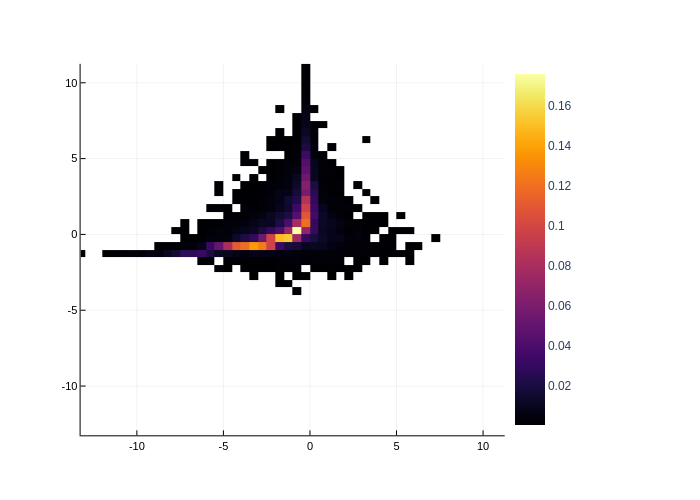

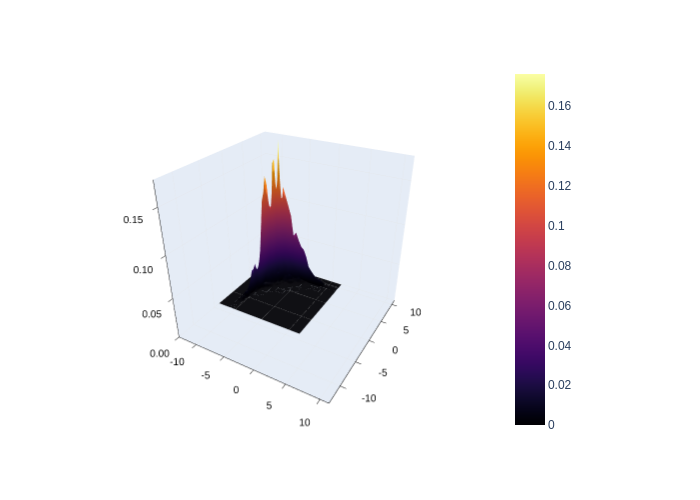

In [98]:
t = 5
data = componentwise_vectors_timepoint(sol, t);
plotHist(data, d)
# r, phi = unzip(map(convertPolar, collect(zip(data[1], data[2]))));

# h_ = fit(Histogram, r .^ 2, nbins=nbins)
# h_ = normalize(h_, mode=:pdf)


# p = plot(h_)
# Dz = map(z -> pdf(D, z), h_.edges[1])
# plot!(h_.edges[1], Dz)

# display(p)
# display(histogram(phi, bins=nbins))